### Table of Contents
1. [Imports and Setup](#imports)
2. [Trying Out Utility Functions](#functions)

###  Imports and Setup <a class="anchor" id="imports"></a>

In [52]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pathlib
import pprint
from tqdm import tqdm
from time import sleep

# Geocoding
from geopy.geocoders import Nominatim, GoogleV3
from geopy import location

# Magic Methods for Jupyter Notebooks
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
tqdm.pandas()

### Trying out Utility Functions

Load CSV with Addresses using Pandas

In [54]:
CORN = "/home/therealmolf/nass_agri_dash/data/agri/corn.csv"

Convert Addresses to Coordinates using Geopy

In [55]:
geolocator = Nominatim(user_agent='http')


def geocode_with_sleep(row) -> pd.Series:
    """
    Get coordinates from a row's state_name.
    Limited geocoding to follow Nominatim Usage Limits.

    Args:
        row: a DataFrame Row

    Returns:
        (pd.Series) The longitude and latitude from the state_name

    """
    
    query = row['state_name']
    sleep(1)
    location = geolocator.geocode(query)

    return pd.Series([location.longitude, location.latitude], \
                     index=['longitude', 'latitude'])


def get_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
        A function that applies a geocoder to the input DataFrame to get
        the coordinates for each.

        Args:
            df (pd.DataFrame): A DataFrame with a state_name column

        Returns:
            (pd.DataFrame): Returns a new DataFrame with longitude and latitude columns
    """

    # No side effects to input df
    df = df.copy()
    df[['longitude', 'latitude']] = df.progress_apply\
        (geocode_with_sleep, axis=1, result_type='expand')

    return df


Convert Coordinates to Points using Shapely

In [56]:
def get_points(df: pd.DataFrame) -> pd.Series:
    """
    Get a Shapely Point Series by from a DataFrame with longitude
    and latitude columns.

    Args:
        df (pd.DataFrame): a DataFrame with longitude and latitude columns

    Returns:
        (pd.Series) A series of Shapely Points
    """

    df = df.copy()
    points = df.progress_apply(lambda row: Point(row.longitude, row.latitude), axis=1)

    return points

Using the Point Series and the DataFrame, Create a GeoDataFrame using GeoPandas

In [57]:
def to_geodataframe(df: pd.DataFrame, points: pd.Series) -> gpd.GeoDataFrame:
    """
    Create a GeoDataFrame using a DataFrame and a Point Series

    Args:
        df (pd.DataFrame): DataFrame where the points series was 
        derived from points (pd.Series): A Shapely Point series

    Returns
        (gpd.GeoDataFrame) A new GeoDataFrame with the Points 
        Series as its geometry column
    """

    df = df.copy()

    geo_df = gpd.GeoDataFrame(df, geometry=points)
    # Change Coordinate Reference System to EPSG 4326
    geo_df.crs = {'init': 'epsg:4326'}

    return geo_df

In [58]:
def csv_to_geodataframe(csv) -> gpd.GeoDataFrame:
    """
        Convert a CSV with state_names into a GeoDataFrame

        Args:
            csv: 

        Returns:
            (gpd.GeoDataFrame) A new GeoDataFrame based on the CSV passed.

    """
    
    df = pd.read_csv(csv)
    coord_df = get_coordinates(df)
    points = get_points(coord_df)
    geo_df = to_geodataframe(coord_df, points)

    return geo_df
    

In [59]:
geo_df = csv_to_geodataframe(CORN)

100%|██████████| 49/49 [01:13<00:00,  1.49s/it]
/home/therealmolf/.virtualenvs/nass_agri_dash/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Plotting the GeoDataFrame

<Axes: >

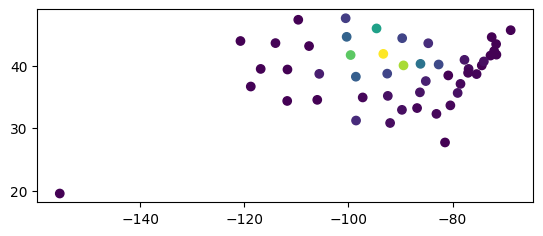

In [60]:
geo_df.plot(column="total_prod")